# Pittsburgh's Next Top Neighborhood

## 🚗 Commutability

In [1]:
import pandas as pd

# read census data
data = pd.read_csv("data/Neighborhoods_with_SNAP_data.csv")

# make easier column names
data['name']    = data['Neighborhood_2010_HOOD']          # neighborhood name
data['drive']   = data['SNAP_All_csv_Commute_to_Work__D'] # drive to work alone
data['carpool'] = data['SNAP_All_csv_Commute_to_Work__C'] # carpool/vanpool
data['public']  = data['SNAP_All_csv_Commute_to_Work__P'] # public transit
data['taxi']    = data['SNAP_All_csv_Commute_to_Work__T'] # taxi
data['motor']   = data['SNAP_All_csv_Commute_to_Work__M'] # motorcycle
data['bike']    = data['SNAP_All_csv_Commute_to_Work__B'] # bike
data['walk']    = data['SNAP_All_csv_Commute_to_Work__W'] # walk
data['other']   = data['SNAP_All_csv_Commute_to_Work__O'] # other

# clean data
data = data.fillna(0)

# constants to determine value of method
# best values are 1, okay are 0.5, bad or null are 0.25
good = 1    # bike, walk
okay = 0.5  # carpool, public transit
bad  = 0.25 # drive, taxi, motorcycle, other

# convert percent value to float
def convert(value):
    value = str(value)
    value = value.replace('%','')
    return float(value)

# iterate through rows, calculate commutability score
for idx, row in data.iterrows():
    score = convert(data.loc[idx,'bike']) + convert(data.loc[idx, 'walk']) # good methods
    score += okay*(convert(data.loc[idx, 'carpool']) + convert(data.loc[idx, 'public'])) # okay methods
    score += bad*(convert(data.loc[idx, 'drive']) + convert(data.loc[idx, 'taxi']) + convert(data.loc[idx, 'motor']) + convert(data.loc[idx, 'other'])) # bad methods
    data.at[idx,'raw'] = score # set neighborhood's commutability score


# find score using Pawel's formula
data['score'] = data['raw']/data['raw'].max()

# find ranks
commute = data[['name','score']] # new dataframe with name and score
commute = commute.sort_values(by=['score'], ascending=False) # sort dataframe by score descending
commute = commute.reset_index(drop = True) # reset index for rank
commute['rank'] = commute.index + 1 # make new column to save rank from index

# view results
commute = commute.sort_values(by=['name'], ascending=True).set_index('name') # sort alphabetically
commute = commute.sort_values(by=['rank'], ascending=True) # sort by rank
commute # print

,score,rank
name,,
Central Oakland,1.000000,1
North Oakland,0.916748,2
Allegheny Center,0.836108,3
Bluff,0.823049,4
Central Business District,0.802481,5
...,...,...
New Homestead,0.350310,86
Summer Hill,0.344107,87
East Carnegie,0.326477,88


## 🕵️‍♂️ Crime

In [2]:
data['score'] = (((1)* data['SNAP_All_csv_Part_1_Crime_per_1']/(data['SNAP_All_csv_Part_1_Crime_per_1'].max())) + ((0.5)* data['SNAP_All_csv_Part_2_Crime_per_1']/(data['SNAP_All_csv_Part_2_Crime_per_1'].max()))) / data['Pop__2010'] * 100 

# view results
crime = data[['name','score']].sort_values(by ='score',ascending=True)
crime = crime.reset_index(drop = True)
crime['rank'] = crime.index + 1
crime = crime.sort_values(by=['rank'], ascending=True).set_index('name')
crime

,score,rank
name,,
Squirrel Hill North,0.000073,1
Squirrel Hill South,0.000089,2
North Oakland,0.000102,3
Brookline,0.000106,4
Greenfield,0.000191,5
...,...,...
Esplen,0.029463,86
West End,0.031678,87
North Shore,0.052048,88


## 🌳 Trees

In [3]:
#import data from csv
t = pd.read_csv("data/trees_data.csv")
trees = t.iloc[:,[48,3,15,16,17,19,20,37,38,39,47]].dropna().sort_values("neighborhood") #isolate just the columns I care about into one dataframe.
trees.head(10)

#Isolate each unique neighborhood
n = trees["neighborhood"].unique().tolist()

#change neighborhood column in dataframe to the indicies
for thing in n :
    trees = trees.replace([thing], n.index(thing))
    
#Function to collect all of the values in a certain column for each neighborhood.
def statsGrab(c, df) :
    statList = []
    stat = 0
    index = 0
    for r in range (len(df)) :
        if (df.iloc[r,0] == index) :
            stat += float(df.iloc[r,c])
        else :
            statList.append(stat)
            index+=1
            stat = float(df.iloc[r,c])
    statList.append(stat)
    return statList

stormValue = statsGrab(2, trees) #Isolate column 2 with storm value dollar benefits
propValue = statsGrab(4, trees) #Isolate column 4 with property value benefits
elecValue = statsGrab(5, trees) #Isolate column 5 with electricity value benefits
airValue = statsGrab(7, trees) #Isolates column 7 with air quality value benefits

#the data is in the wrong orientation for a dataframe. Time to rework it...
index = []
scoresList = [[]]
for i in range(90) :  #Creates a 2D array where the data is arranged into 90 rows and 5 columns so it can be imported into a dataframe.
    index.append(i)
    
    scoresList[i].append(n[i])
    scoresList[i].append(stormValue[i])
    scoresList[i].append(propValue[i])
    scoresList[i].append(elecValue[i])
    scoresList[i].append(airValue[i])
    
    scoresList.insert(i+1, [])
    
del scoresList[90]
    
scores = pd.DataFrame(scoresList,
                      columns = ['Neighborhood', 'Stormwater Benefits', 'Property Value', 'Electric Benefits', 'Air Quality Benefits'], index=index)

stormRank = []
propRank = []
elecRank = []
airRank = []

for r in range(90) : #create arrays to hold the rank values.
    stormRank.append(0)
    propRank.append(0)
    elecRank.append(0)
    airRank.append(0)

#sort each of the sheets by the values (lowest to highest)
sScores = scores.sort_values("Stormwater Benefits")
pScores = scores.sort_values("Property Value")
eScores = scores.sort_values("Electric Benefits")
aScores = scores.sort_values("Air Quality Benefits")

for r in range(90) : #assign ranks with 90 at the lowest and 1 at the highest dollar value
    i = sScores.index.tolist()
    stormRank[i[r]] = (90-r)
    
    i = pScores.index.tolist()
    propRank[i[r]] = (90-r)
    
    i = eScores.index.tolist()
    elecRank[i[r]] = (90-r)
    
    i = aScores.index.tolist()
    airRank[i[r]] = (90-r)
    
#Once again, the data is in the wrong orientation for a dataframe, but I want to plot it before determining final scores.
index = []
scoresList = [[]]
for i in range(90) :  
    index.append(i)
    
    scoresList[i].append(n[i])
    scoresList[i].append(stormRank[i])
    scoresList[i].append(propRank[i])
    scoresList[i].append(elecRank[i])
    scoresList[i].append(airRank[i])
    
    scoresList.insert(i+1, [])
    
del scoresList[90]
    
rank = pd.DataFrame(scoresList,
                      columns = ['Neighborhood', 'Stormwater Rank', 'Property Rank', 'Electric Rank', 'Air Quality Rank'], index=index)

C:\Users\Max\anaconda3\envs\cmpinf0010\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


Here's how each neighborhood ranks! The smaller the bar, the better the rank.

<AxesSubplot:xlabel='Neighborhood'>

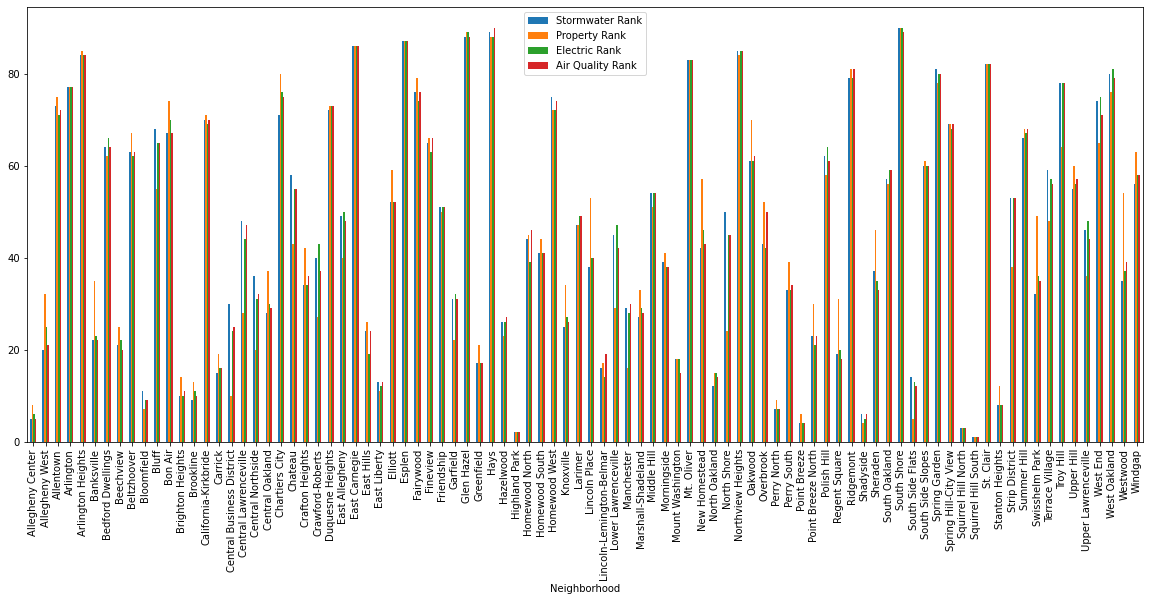

In [4]:
rank.plot.bar(x='Neighborhood', figsize=(20,8))

In [5]:
nRank = []
for r in range(90) : #Calculate the total rank for each metric
    rankSum = stormRank[r] + propRank[r] + elecRank[r] + airRank[r]
    nRank.append(rankSum)
    
index = []
rank = [[]]
for i in range(90) :  #Rearrange the data for a dataframe.
    index.append(i)
    
    rank[i].append(n[i])
    rank[i].append(nRank[i])
    
    rank.insert(i+1, [])
    
del rank[90]
    
rank = pd.DataFrame(rank,
                      columns = ['Neighborhood', 'Rank'], index=index)

rank = rank.sort_values('Rank')

#For importing into final.ipynb (re-rank from 1-90)

rankList = []
for r in range(90) :
    rankList.append(0)
    
i = rank.index.tolist()
for r in range(90) :
    rankList[i[r]] = (r+1)

scoresList = [[]]
for i in range(90) :      
    scoresList[i].append(n[i])
    scoresList[i].append(rankList[i])
    
    scoresList.insert(i+1, [])
    
del scoresList[90]

finalRank = pd.DataFrame(scoresList, columns=['Neighborhood', 'Rank']).sort_values("Rank")
finalRank

,Neighborhood,Rank
76,Squirrel Hill South,1
39,Highland Park,2
75,Squirrel Hill North,3
62,Point Breeze,4
67,Shadyside,5
...,...,...
26,East Carnegie,86
30,Esplen,87
35,Glen Hazel,88
37,Hays,89


## 🥫 Smart Trash Cans

C:\Users\Max\anaconda3\envs\cmpinf0010\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


<AxesSubplot:xlabel='Neighborhood'>

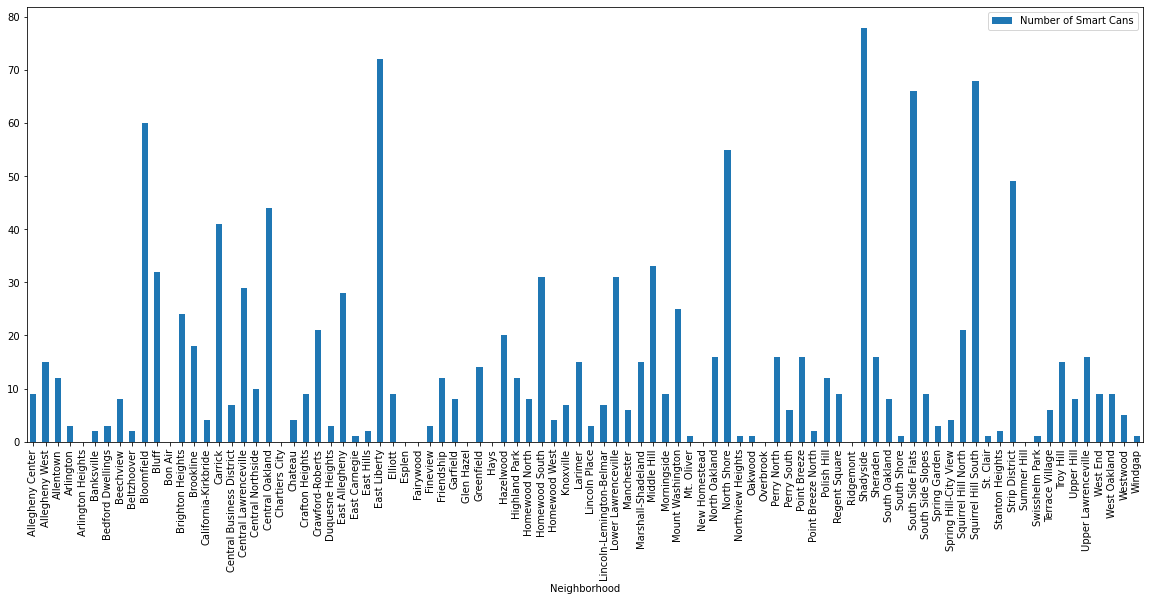

In [6]:
c = pd.read_csv("data/trash_can_data.csv")
cans = c.iloc[:,[9]].sort_values("neighborhood").dropna()

#Pulling in trees data to get all 90 neighborhoods (cans data only has 79 neighborhoods)
t = pd.read_csv("data/trees_data.csv").dropna().sort_values('neighborhood')
n = t['neighborhood'].unique().tolist() #create an array with all the neighborhoods in alphabetical order

total = [] #create an array of size 90 (filled with 0s)
for r in range(90) :
    total.append(0)

for r in range(len(cans)) : #counts how many trash cans are in each neighborhood.
    neighborhood = cans.iloc[r,0] #find the neighborhood for each entry in the cans dataframe.
    i = n.index(neighborhood) #find the index of that neighborhood in the n array.
    total[i]+=1 #add one to the corresponding index value in total.
    
numCans = [[]] #Create an empty 2D Array
for i in range(90) : #Rearrange the data into 90 rows and 2 columns to make it readable by pandas.
    numCans[i].append(n[i]) #Add the neighborhood to the current row (i)
    numCans[i].append(total[i]) #Add the number of trash cans to the current row (i)
    
    numCans.insert(i+1, []) #Add another row
    
del numCans[90] #Delete the extra row added by the final pass of the loop.

totalCans = pd.DataFrame(numCans, columns=['Neighborhood', 'Number of Smart Cans'])
totalCans.plot.bar(x="Neighborhood", figsize=(20,8))

In [7]:
ranked = totalCans.sort_values("Number of Smart Cans")
rankList = []
for r in range(90) : #Create a rank array filled with 0s
    rankList.append(0)

for r in range(90) : #Add rankings
    i = ranked.index.tolist()
    rankList[i[r]] = (90-r)
    
numCans = [[]]
for i in range(90) : #Rearrange the data again for the dataframe
    numCans[i].append(n[i])
    numCans[i].append(rankList[i])
    
    numCans.insert(i+1, [])
    
del numCans[90]

canRank = pd.DataFrame(numCans, columns = ['Neighborhood', 'Ranking'])
canRank = canRank.sort_values('Ranking')

canRank

,Neighborhood,Ranking
67,Shadyside,1
28,East Liberty,2
76,Squirrel Hill South,3
71,South Side Flats,4
9,Bloomfield,5
...,...,...
4,Arlington Heights,86
37,Hays,87
54,New Homestead,88
59,Overbrook,89


## Final Ranking 🎖

In [8]:
# create final rank dataframe
final = data[['name']]
final = final.sort_values(by='name').set_index('name')

# add individual ranks
# commute
commute = commute.sort_values('name')
final['commute rank'] = commute['rank']*3 # weight of 3
# crime
crime = crime.sort_values('name')
final['crime rank'] = crime['rank']*5 # weight of 5
# trees
finalRank = finalRank.sort_values('Neighborhood')
final['tree rank'] = (finalRank['Rank']*2).tolist() # weight of 2
# trash cans
canRank = canRank.sort_values('Neighborhood')
final['can rank'] = canRank['Ranking'].tolist() # weight of 1

# sum ranks
final["sum"] = final.sum(axis=1)

# sort by final rank
final = final.sort_values('sum')

# print results
print("The best neighborhood in Pittsburgh is... "+str(final.index[0])+"!")
final

The best neighborhood in Pittsburgh is... Squirrel Hill North!


,commute rank,crime rank,tree rank,can rank,sum
name,,,,,
Squirrel Hill North,36,5,6,19,66
North Oakland,6,15,28,23,72
Shadyside,51,30,10,1,92
Squirrel Hill South,135,10,2,3,150
Bloomfield,33,110,18,5,166
...,...,...,...,...,...
Chartiers City,243,350,152,90,835
West End,216,435,142,42,835
Chateau,270,450,106,57,883


<AxesSubplot:title={'center':'Pittsburgh Neighborhoods Ranked'}>

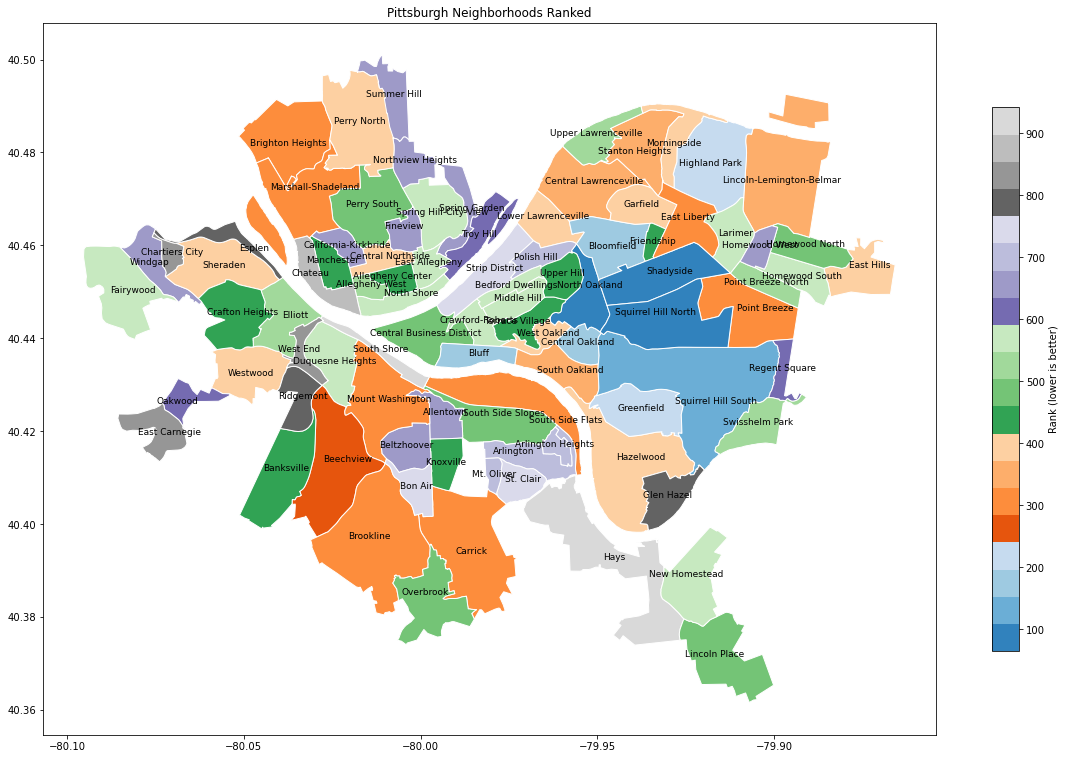

In [12]:
import geopandas as gpd
%matplotlib inline
from matplotlib import pyplot as plt

# read in map data
pgh = gpd.read_file("data/Neighborhoods/Neighborhoods_.shp")

# project map data to lat/lon
pgh['geometry'] = pgh['geometry'].to_crs(epsg=4326)

# add neighborhood labels to map
def label_map():
    pgh['coords'] = pgh['geometry'].apply(lambda x: x.representative_point().coords[:])
    pgh['coords'] = [coords[0] for coords in pgh['coords']]
    for idx, row in pgh.iterrows():
        plt.annotate(text = row['hood'], xy=row['coords'],
                     horizontalalignment='center', size=9)

# add scores to map
pgh = pgh.merge(final, how='left', left_on='hood', right_on='name')

# plot map
fig,ax = plt.subplots(figsize = (20,20)) # plot size
label_map()
ax.set_title('Pittsburgh Neighborhoods Ranked')
pgh.plot(ax=ax, column='sum', edgecolor="white", cmap='tab20c', legend=True, legend_kwds={'label': "Rank (lower is better)", 'shrink': 0.5})

## 👓 Group Summary

The goal of our project was to determine which of the many neighborhoods of Pittsburgh is the best by examining data related to commutability, trees, smart trash cans, and crime rates related to these neighborhoods.

Based on the best neighborhood for each individual data category (commutability, trees, etc.), an overall ranking was created by scaling the rankings of each data category based on its importance in determining how good the neighborhood was. For example, because crime rate is more important in determining which neighborhood is better to live in, it’s ranking was multiplied by a factor of 5, which is much higher when compared to the commutability rank, which was just multiplied by a factor of 3. At the end of the scaling, all of the ranks for each category were added, and the neighborhood with the lowest number was determined to be the “best” neighborhood in Pittsburgh.

Based on our data and calculations, the overall best neighborhood was **Squirrel Hill North**.